# Density-based clustering

In [167]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.axes as axes
from sklearn.cluster import DBSCAN
import seaborn as sns
from tqdm.notebook import tqdm

In [71]:
# read customer dataframe
df = pd.read_csv('datasets/customer_dataframe.csv', sep='\t', index_col=0)

Perform some dimensionality reduction by picking only the main attributes
for describing a customer's shopping behaviour

In [72]:
df_reduct = df[['TProd', 'MeanProdOrder', 'MeanSaleOrder', 'MeanPSale']]
df_reduct.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4333 entries, 17850 to 12713
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   TProd          4333 non-null   int64  
 1   MeanProdOrder  4333 non-null   float64
 2   MeanSaleOrder  4333 non-null   float64
 3   MeanPSale      4333 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 169.3 KB


In [73]:
df_reduct.describe()

,TProd,MeanProdOrder,MeanSaleOrder,MeanPSale
count,4333.000000,4333.000000,4333.000000,4333.000000
mean,1129.535657,201.104614,327.882896,3.492819
std,4692.695935,274.590134,395.336014,8.997404
min,0.000000,0.000000,-0.000000,0.122000
25%,157.000000,80.500000,155.050000,2.160000
50%,370.000000,140.167000,241.900000,2.834000
75%,971.000000,237.750000,371.560000,3.712000
max,196556.000000,7824.000000,9904.875000,434.650000


<AxesSubplot:>

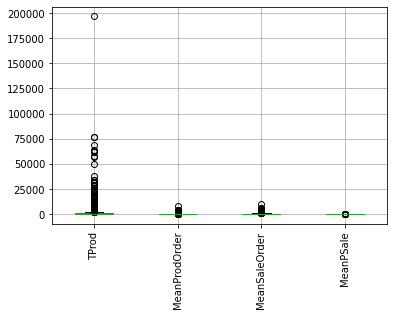

In [74]:
df_reduct.boxplot(list(df_reduct.columns), rot=90)

## Preprocessing - Normalization

In [75]:
# standard normalization: remove mean and scale to unit variance
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_norm = scaler.fit_transform(df_reduct.values)
df_norm = pd.DataFrame(df_norm, columns=df_reduct.columns)

In [76]:
df_norm.describe()

,TProd,MeanProdOrder,MeanSaleOrder,MeanPSale
count,4.333000e+03,4.333000e+03,4.333000e+03,4.333000e+03
mean,1.311872e-17,3.279680e-17,-5.493464e-17,4.181592e-17
std,1.000115e+00,1.000115e+00,1.000115e+00,1.000115e+00
min,-2.407286e-01,-7.324656e-01,-8.294735e-01,-3.746867e-01
25%,-2.072685e-01,-4.392675e-01,-4.372302e-01,-1.481508e-01
50%,-1.618735e-01,-2.219477e-01,-2.175183e-01,-7.323169e-02
75%,-3.378739e-02,1.334703e-01,1.104937e-01,2.436327e-02
max,4.164962e+01,2.776420e+01,2.422774e+01,4.792570e+01


<AxesSubplot:>

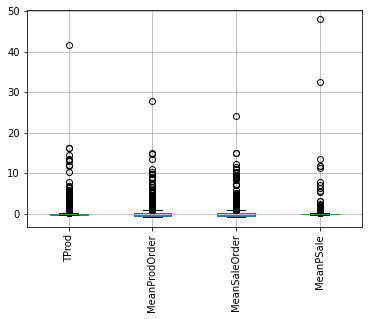

In [77]:
df_norm.boxplot(list(df_norm.columns), rot=90)

## DBSCAN

### Approach 1:

In [158]:
from scipy.spatial.distance import pdist, squareform
dist = pdist(X=df_norm, metric='euclidean')  #pair-wise distance: how every record is far from all others
dist = squareform(dist) #distance matrix given the vector dist

In [159]:
kmin = 3
kmax = 30
kth_distances = {}
for k in range(kmin, kmax + 1): kth_distances[k] = list()   # initialize k lists

# for every row of the distance matrix...
for d in dist:
    # argsort returns the indexes that would sort d
    indexes_to_sort_d = np.argsort(d)
    for k in range(kmin, kmax + 1):
        # append to kth_distances[k] the value in d that corresponds
        # to the distance of the i-th point (record) from its k-th nn.
        # it's like: kth_distances[k].append(sorted_d[k])), but we get "sorted_d[k]" by d[indexes_to_sort_d[k]]
        kth_distances[k].append(d[ indexes_to_sort_d[ k ] ])

Plot, for every value of k in [kmin, kmax], the sorted distances

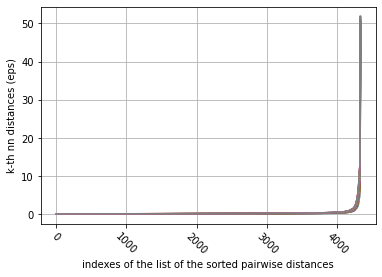

In [160]:
for k in kth_distances.keys():
    plt.plot(range(0, len(kth_distances[k])), sorted(kth_distances[k]))

plt.ylabel('k-th nn distances (eps)')
plt.xlabel('indexes of the list of the sorted pairwise distances')
plt.xticks(rotation=-45)
plt.tick_params(axis='both', which='major')
plt.grid()
plt.show()

Same plot with the median value of [kmin, kmax] for every x because the plot seems uniform for every k.<br>
Just to have a cleaner view of the plot

In [161]:
kmedian = list()
for i in tqdm(range(len(kth_distances[kmin])), total=len(kth_distances[kmin])):
    aux = list()
    for k in kth_distances.keys(): aux.append(sorted(kth_distances[k])[i])
    kmedian.append(np.median(aux))

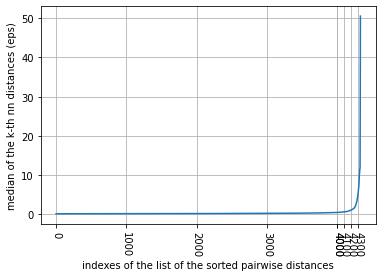

In [194]:
plt.plot(range(0,len(kth_distances[kmin])), kmedian) #kmedian already sorted
plt.ylabel('median of the k-th nn distances (eps)')
plt.xlabel('indexes of the list of the sorted pairwise distances')

xticks = []
for i in range(0, 4001, 1000): xticks.append(i)
for i in range(4000, len(kth_distances[kmin]), 100): xticks.append(i)
plt.xticks(xticks, rotation=-90)
plt.tick_params(axis='both', which='major')
plt.grid()
plt.show()

IndexError: list index out of range

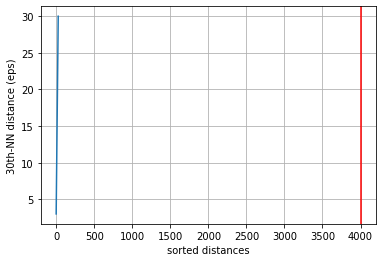

In [192]:
plt.figure(num=1)
plt.plot(range(0, len(kth_distances)), sorted(kth_distances))
plt.ylabel(f'{k}th-NN distance (eps)')
plt.xlabel('sorted distances')
plt.tick_params(axis='both', which='major')
plt.grid()
elb = 4000
plt.axvline(x=elb, color='red', linestyle='-')
plt.axhline(y=sorted(kth_distances)[elb], color='red', linestyle='-')
plt.show()
print(f"Elbow of {k}th-NN distances plot: x = {elb} --> eps = {sorted(kth_distances)[elb]}")

### Approach 2:
### Grid search for _eps_ and <i>min_samples</i>

In [65]:
from sklearn.neighbors import NearestNeighbors

# func to get metrics to evaluate the clustering done with certain eps and min_samples
def get_metrics(eps, ms, dataset, iter_):

    # Fitting
    dbscan = DBSCAN(eps=eps, min_samples=ms)
    dbscan.fit(dataset)

    # Mean Noise Point Distance metric
    noise_indices = (dbscan.labels_ == -1)  #list of booleans
    if True in noise_indices:
        nbrs = NearestNeighbors(n_neighbors = 5).fit(dataset)
        distances, _ = nbrs.kneighbors(dataset)   #returns indices of and distances to the neighbors of each point
        noise_distances = distances[noise_indices, 1 : ]
        noise_mean_distance = round(noise_distances.mean(), 3)
    else:
        noise_mean_distance = None

    # Number of found Clusters metric
    number_of_clusters = len(np.unique(dbscan.labels_[dbscan.labels_ >= 0]))

    # Log
    print("%3d | Tested with eps = %3s and min_samples = %3s | %5s\t%4s" % (iter_, eps, ms, str(noise_mean_distance), number_of_clusters))

    return noise_mean_distance, number_of_clusters

In [66]:
# Lists for the params to test in the grid search
gs_eps_list = []
for eps in np.arange(0.05, 0.40, 0.05): gs_eps_list.append(round(eps, 2))
for eps in np.arange(1.5, 3., 0.5): gs_eps_list.append(round(eps, 2))
gs_ms_list = range(3, 16, 3)

print("Grid search parameters:")
print("eps:", gs_eps_list)
print("min_samples:", list(gs_ms_list))

Grid search parameters:
eps: [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 1.5, 2.0, 2.5]
min_samples: [3, 6, 9, 12, 15]


Dataframes to contain the results of the grid search

In [67]:
# Dataframe for the metric on the avg distance of the noise points from the K nearest ones
results_noise = pd.DataFrame(
    data = np.zeros((len(gs_eps_list),len(gs_ms_list))), # Empty dataframe
    columns = gs_ms_list,
    index = gs_eps_list
)

# Dataframe for the metric on the number of clusters
results_clusters = pd.DataFrame(
    data = np.zeros((len(gs_eps_list),len(gs_ms_list))), # Empty dataframe
    columns = gs_ms_list,
    index = gs_eps_list
)

Grid search cycle:

In [68]:
# Grid search cycle
i = 0

print("ITER| INFO%s |  DIST    # CLUSTERS" % (' '*39))
print("-"*73)

for eps in tqdm(gs_eps_list, total=len(gs_eps_list), desc='Proceeding of grid search'):
    for ms in gs_ms_list:
        i += 1

        # Compute metrics
        noise_metric, clusters_metric = get_metrics(eps, ms, df_norm, i)

        # Insert results in the apposite dataframes
        results_noise.loc[eps, ms] = noise_metric
        results_clusters.loc[eps, ms] = clusters_metric

ITER| INFO                                        |  DIST    # CLUSTERS
-------------------------------------------------------------------------
  1 | Tested with eps = 0.05 and min_samples =   3 | 0.258	  94
  2 | Tested with eps = 0.05 and min_samples =   6 | 0.207	  25
  3 | Tested with eps = 0.05 and min_samples =   9 | 0.184	   8
  4 | Tested with eps = 0.05 and min_samples =  12 | 0.175	   4
  5 | Tested with eps = 0.05 and min_samples =  15 | 0.168	   3
  6 | Tested with eps = 0.1 and min_samples =   3 | 0.536	  42
  7 | Tested with eps = 0.1 and min_samples =   6 |  0.42	  10
  8 | Tested with eps = 0.1 and min_samples =   9 | 0.367	   2
  9 | Tested with eps = 0.1 and min_samples =  12 | 0.341	   2
 10 | Tested with eps = 0.1 and min_samples =  15 | 0.325	   2
 11 | Tested with eps = 0.15 and min_samples =   3 | 0.913	  19
 12 | Tested with eps = 0.15 and min_samples =   6 | 0.683	   6
 13 | Tested with eps = 0.15 and min_samples =   9 | 0.592	   4
 14 | Tested with eps = 0.1

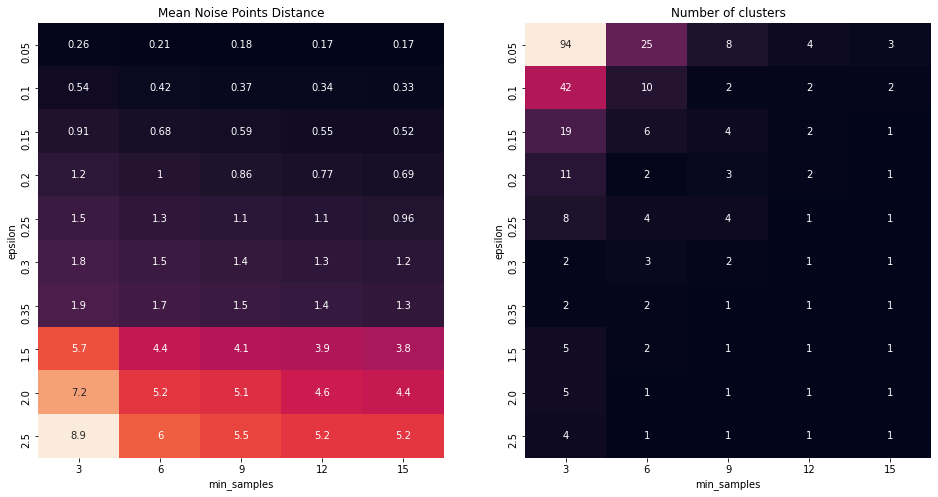

In [69]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))
sns.heatmap(results_noise, annot = True, ax = ax1, cbar = False).set_title("Mean Noise Points Distance")
sns.heatmap(results_clusters, annot = True, ax = ax2, cbar = False).set_title("Number of clusters")
ax1.set_xlabel("min_samples")
ax2.set_xlabel("min_samples")
ax1.set_ylabel("epsilon")
ax2.set_ylabel("epsilon")
plt.show()
